# Installation

### 1. Make new conda environment
Install JAX by creating a fresh `conda` environment. 

As a side note, [`mamba`](https://mamba.readthedocs.io/en/latest/installation/mamba-installation.html) is a fast version of `conda` that uses `conda-forge` as its main channel (this is the channel you should always be using for science work).

With `conda` (`mamba` already does this by default):
```bash
conda update conda
conda config --add channels conda-forge
conda config --set channel_priority strict
```
Make environment:
```bash
conda create -n jax_intro python=3.12
conda activate jax_intro
```

### 2. Install JAX

Using JAX requires installing two packages: `jax`, which is pure Python and cross-platform, and `jaxlib` which contains compiled binaries, and requires different builds for different operating systems and accelerators.

-- CPU-only (Linux/macOS/Windows):
```bash
pip install -U jax
```

-- GPU (NVIDIA, CUDA 12):
```bash
pip install -U "jax[cuda12]"
```

-- GPU (Mac M chips): (Experimental)

Follow: https://developer.apple.com/metal/jax/
```bash
pip install -U "jax[cuda12]"
```

### 3. Install remaining packages
```bash
conda install matplotlib numpy scipy astropy h5py
```



# Import Matplotlib

In [3]:
%matplotlib inline

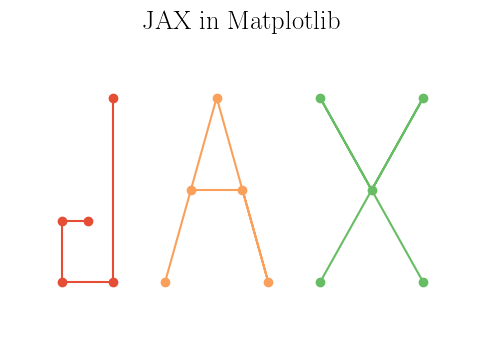

In [16]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rc('font', family="serif")
plt.rc('font', size=16)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
plt.rc('figure', figsize=(6,4)) 

cmap = plt.get_cmap("RdYlGn")
plt.subplots(1,1)
# Define points for "J"
J_x = [1, 1, 0, 0, 0.5]
J_y = [3, 0, 0, 1, 1]

# Define points for "A"
A_x = [2, 3, 4, 3.5, 2.5]
A_y = [0, 3, 0, 1.5, 1.5]

# Define points for "X"
X_x = [5, 7, 6, 5, 7]
X_y = [0, 3, 1.5, 3, 0]

# Plot the points as lines
plt.plot(J_x, J_y, marker='o', linestyle='-', color=cmap(0.15), label='J')
plt.plot(A_x, A_y, marker='o', linestyle='-', color=cmap(0.28), label='A')
plt.plot(X_x, X_y, marker='o', linestyle='-', color=cmap(0.8), label='X')

# Styling
plt.xlim(-1, 8)
plt.ylim(-1, 4)
plt.axis("off")
plt.title("JAX in Matplotlib")

# Show the plot
plt.show()

# Introduction to JAX

This notebook summarizes with examples some of the great JAX documentation available at: https://docs.jax.dev/en/latest/quickstart.html

JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

Even if you are not interested in machine learning, you can exploit JAX to make your programs **faster** and **differentiable**.

Coding with JAX is largely similar to coding with Numpy and Python's pure functions, with minimal (but important) rules, that yields accelerated code in CPUs, and automatic portability to accelerated machines (GPUs, TPUs).

JAX let's you calculate fast gradients with machine-level precision of your functions. The feature of differentiation let's you use modern gradient-based optimization (BFGS, Adam) or inference (HMC, NUTS) techniques. These converge much faster.

## Quickstart
JAX is a library for array-oriented numerical computation (à la NumPy), with automatic differentiation and JIT compilation to enable high-performance machine learning research.

The main features of JAX can be summarized as: 
- `jax.numpy`: JAX provides a unified *NumPy-like* interface to computations that run on *CPU, GPU, or TPU, in local or distributed settings*.

- `jax.jit`: JAX features built-in *Just-In-Time (JIT)* compilation via *Open XLA*, an open-source machine learning compiler ecosystem.

- `jax.grad`: JAX functions support efficient evaluation of gradients via its *automatic differentiation* transformations.

- `jax.vmap`: JAX functions can be *automatically vectorized* to efficiently map them over arrays representing batches of inputs.


JAX has also implemented part of scipy, accessible through `jax.scipy`.

# Jax as Numpy 

You can think of JAX as a differentiable Numpy that runs on accelerators.

Most JAX usage is through the familiar `jax.numpy` API, which is typically imported under the `jnp` alias:



In [ ]:
#__ = plt.style.use("./diffstar.mplstyle")
import numpy as np


In [ ]:
import numpy as np
import jax.numpy as jnp
import 

## Basics
### JAX Arrays